In [64]:
#Import libraries 
import numpy as np
import math
import matplotlib.pyplot as plt
from numba import njit
import os 

In [3]:
#Define constants 

pi = np.pi
deg2rad = pi/180
rad2deg = 1/deg2rad


# This is the main script in the steady state version of the North model

# Set physical parameters
S0 = 1354.0 #The solar constant, corresponds to Q_0=338.5 W/m2
L = 1 #the relative strength of the solar constant, 1 = present
A = 203.3 #Infrared flux A-constant. In units W/m2. In North A = 201.4
B = 2.09 #Infrared flux B-constant. In units W/(m2 * K). In North B = 1.45 
Dmag = 0.44 #Infrared flux D-constant. (Absorps B) In units W/(m2 * K). 
Cl = 9.8 #unit W/m2 * yr/K. Heat Capacity of the system
Toffset = 0 
coldstart = 0 #1, then Toffset is set to -40 for a cold initial temperature
hadleyflag = 0 #0: no hadley cell
albedoflag = 1 #1: albedo feedback with T_crit, otherwise a fixed boundary at 72deg

# Define a function that initializes the model and calculates T
# Set model parameters
jmx = 251 #antallet af dataframes i some form
delt = 1/50 
NMAX = 100000
delx = 2/jmx #bredden på x?

# define an array with latitude steps in both x and phi
x = np.linspace(-1, 1, jmx)
phi = np.arcsin(x) * rad2deg




[3.24381652e+15 8.37381652e+15 1.35038165e+16 ... 1.02478538e+19
 1.02529838e+19 1.02581138e+19]


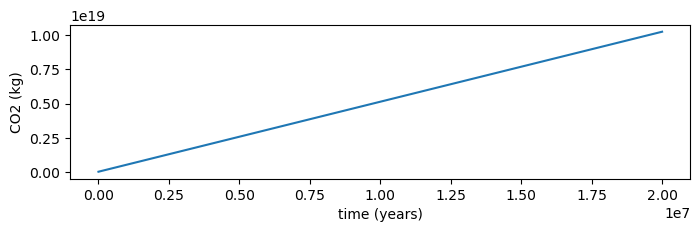

In [4]:
# inputs
N = 1.79 * 10 ** (20) # mol
ppm = 1e-6
M_co2 = 42.44e-3   # kg/mol

Co2_Volcanic = 51.3 * 1e9      # kg / yr
Co2_start    = 427.0       # ppm

Co2_mol = N * Co2_start * ppm # mol
Co2_kg = Co2_mol * M_co2 # kg

Co2_Volcanic_pmmv = Co2_Volcanic / (M_co2 * N) / ppm # ppm / year


time_step = 10000 # years
time_scale = 20_000_000 # years
n_steps = int(time_scale/time_step)
Co2_array = np.zeros(int(time_scale/time_step))
for t in range(0, time_scale, time_step):
    Co2_array[int(t/time_step)] = Co2_kg + Co2_Volcanic * t * 10
print(Co2_array)


plt.figure(figsize=(8,2)) 
plt.plot(np.arange(0, time_scale, time_step), Co2_array)
plt.xlabel('time (years)')
plt.ylabel('CO2 (kg)')
plt.show()

In [5]:
CO2_PPM_array = np.arange(0, time_scale, time_step) *  Co2_Volcanic_pmmv + Co2_start

In [6]:
print(np.shape(CO2_PPM_array))

(2000,)


In [7]:
# Define the latitude dependent insolation function. xs is the latitudal variable
@njit
def Q_lat(xs, L=1.0, S0=1354.0):
    return L * (S0 / 4.0) * (1.0 - 0.241 * (3.0 * np.square(xs) - 1.0))

In [8]:
# Define the albedo function
@njit
def albedo(T, xs, jmx, albedoflag):
    alb = np.ones(jmx) * 0.3  # baseline Earth's albedo
    if albedoflag == 1:
        # Variable snowline: temperature-dependent
        for j in range(jmx):
            if T[j] <= -10.0:
                alb[j] = 0.6
    else:
        # Fixed snowline at the poles
        for j in range(jmx):
            if abs(xs[j]) >= 0.95:
                alb[j] = 0.6
    return alb

In [9]:
# Define the heat diffusion function
def D_lat(xs, D0=0.44, hadleyflag=False):   
    n = len(xs)
    D = np.empty(n)
    if hadleyflag == 1:  #latitude dependent diffusion with hadley cell
        sin30 = np.sin(30.0 * np.pi / 180.0)
        for i in range(n):
            D[i] = D0 * (1.0 + 9.0 * np.exp(-((xs[i] / sin30) ** 6)))
    else: # constant diffusion without hadley cell
        for i in range(n):
            D[i] = D0
    return D

In [10]:
def A_func(green_has_con):
    """This function takes the greenhouse gas concentration of CO2 and calculates the Infrared flux A-constant. In units W/m2"""
    phi = np.log(green_has_con/300) #unit in parts per million
    return -326.4 + 9.161 * phi - 3.164 * phi**2 + 0.5468 * phi**3

In [11]:
def B_func(green_has_con):
    """This function takes the greenhouse gas concentration of CO2 and calculates the Infrared flux B-constant. In units (m2 * K)"""
    phi = np.log(green_has_con/300) #unit in parts per million
    return 1.953 - 0.04866 * phi + 0.01309 * phi**2 - 0.002577 * phi**3

In [12]:
A_array = A_func(CO2_PPM_array)

B_array = B_func(CO2_PPM_array)

In [13]:
# Define functions used for matrix operations when solving the equations


@njit
def setupfastMh(delx, jmx, D, B, Cl, delt):
    # Create lambda array (diffusion coefficients)
    lam = np.empty(jmx)
    x_vals = np.linspace(-1.0, 1.0, jmx)
    for j in range(jmx):
        lam[j] = D[j] * (1.0 - x_vals[j] * x_vals[j]) / (delx * delx)
    
    # Initialize M matrix
    M = np.zeros((jmx, jmx))
    
    # Boundary points
    M[0, 0] = -B - lam[1]
    M[0, 1] = lam[1]
    M[jmx - 1, jmx - 2] = lam[jmx - 1]
    M[jmx - 1, jmx - 1] = -B - lam[jmx - 1]
    
    # Interior points
    for j in range(1, jmx - 1):
        M[j, j - 1] = lam[j]
        M[j, j] = -B - (lam[j + 1] + lam[j])
        M[j, j + 1] = lam[j + 1]
    
    # Divide by heat capacity
    M = M / Cl
    return M

@njit
def setupfastinvM(Mh, jmx, delt):
    # Construct M'
    M = 0.5 * Mh.copy()
    for j in range(jmx):
        M[j, j] -= 1.0 / delt
    # Invert (Numba supports np.linalg.inv)
    invM = np.linalg.inv(M)
    return invM

In [14]:
# Calculate an array of annual mean insolation for the latitudes steps
S = Q_lat(x, L, S0)  

A = A_array[0] + 273.15 * B_array[0] 
B = B_array[0]
    
# Calculate an array of diffussion constants
xmp = np.arange(-1, 1 + delx, delx)
D = D_lat(xmp, Dmag, hadleyflag)

# define initial T array
T = 0 * (1 - 2 * np.square(x))
Toffset = -40 
T = T + Toffset
Tinit = T

# Calculate global mean temperature
Tglob = np.mean(T) #ok to take the mean when we use x

# Calculate initial albedo
alb = albedo(T, x, jmx, albedoflag)

# Initial boundary conditions
src = (1 - alb) * S/Cl - A/Cl
Mh = setupfastMh(delx, jmx, D, B, Cl, delt)
invM = setupfastinvM(Mh, jmx, delt)
h = np.dot(Mh, T) + src

for n in range(NMAX): #Should be NMAX
        Tglob_prev = Tglob
        # calculate src for this loop
        alb = albedo(T, x, jmx, albedoflag)
        src = (1 - alb) * S/Cl - A/Cl
        # Calculate new T.
        T = -np.dot(invM, 0.5* (h + src) + T/delt)

        # Calculate h for next loop.
        h = np.dot(Mh, T) + src
        # Check to see if global mean temperature has converged
        Tglob = np.mean(T)
        #print(Tglob)
        Tchange = Tglob - Tglob_prev
        if abs(Tchange)< 1e-12:
            break

# Compute meridional heat flux and its convergence
a = 6.37e+6; # earth radius in meters
Mh = setupfastMh(delx, jmx, D, 0, 1, delt)
invM = setupfastinvM(Mh, jmx, delt)
Dmp = D[0:jmx]
divF = np.dot(Mh, T)
F = -2 * math.pi * a * a * np.sqrt(1 - x*x) * Dmp * np.gradient(T,delx)


In [15]:
import math

@njit
def north_model(T_input, A_val, B_val, D_arr, x, Cl, delx, jmx, delt, NMAX, S0,
                L=1.0, hadleyflag=0, albedoflag=1):
    
    A = A_val + B_val * 273.15
    B = B_val
    D = D_arr.copy()
    T = T_input.copy()
    
    # Latitude-dependent insolation
    S = Q_lat(x, L, S0)

    # Initial albedo
    alb = albedo(T, x, jmx, albedoflag)

    # Boundary conditions
    src = (1.0 - alb) * S / Cl - A / Cl
    Mh = setupfastMh(delx, jmx, D, B, Cl, delt)
    invM = setupfastinvM(Mh, jmx, delt)
    h = np.dot(Mh, T) + src

    Tglob = np.mean(T)
    
    for n in range(NMAX):
        Tglob_prev = Tglob
        
        # Update albedo & source
        alb = albedo(T, x, jmx, albedoflag)
        src = (1.0 - alb) * S / Cl - A / Cl

        # Temperature update
        T = -np.dot(invM, 0.5 * (h + src) + T / delt)

        # Update h
        h = np.dot(Mh, T) + src
        
        # Check convergence
        Tglob = np.mean(T)
        if abs(Tglob - Tglob_prev) < 1e-12:
            break

    # Compute meridional heat flux
    a = 6.37e6
    Mh = setupfastMh(delx, jmx, D, 0.0, 1.0, delt)
    invM = setupfastinvM(Mh, jmx, delt)
    Dmp = D[:jmx]
    divF = np.dot(Mh, T)

    # Finite-difference gradient instead of np.gradient
    gradT = np.empty_like(T)
    gradT[0] = (T[1] - T[0]) / delx
    for i in range(1, jmx - 1):
        gradT[i] = (T[i + 1] - T[i - 1]) / (2.0 * delx)
    gradT[jmx - 1] = (T[jmx - 1] - T[jmx - 2]) / delx

    F = -2.0 * math.pi * a * a * np.sqrt(1.0 - x * x) * Dmp * gradT

    return T, Tglob, F, alb, S

In [16]:
T_array = np.zeros((np.shape(CO2_PPM_array)[0], np.shape(T)[0]))
F_array = np.zeros((np.shape(CO2_PPM_array)[0], np.shape(F)[0]))
Tglob_array = np.zeros(np.shape(CO2_PPM_array))
alb_array = np.zeros((np.shape(CO2_PPM_array)[0], np.shape(alb)[0]))
S_array = np.zeros((np.shape(CO2_PPM_array)[0], np.shape(S)[0]))

In [17]:
# define initial T array
T = 0 * (1 - 2 * np.square(x))
Toffset = -40
T = T + Toffset
Tinit = T


In [18]:
%%time
# define initial T array
T = 0 * (1 - 2 * np.square(x))
Toffset = -40
T = T + Toffset
Tinit = T
T_up = T

#north_model(T_input = T_up, A_val = A_array[i], B_val = B_array[i], D_arr = D, L=1, hadleyflag=0, albedoflag=1)
for i in range(2000):
    T_0, T_glob_0, F_0, alb_0, S_0 = north_model(T_input = T_up, A_val = A_array[i], B_val = B_array[i], D_arr = D, x = x, Cl = Cl, delx = delx, jmx = jmx, delt = delt, NMAX = NMAX, S0 = S0, L=1.0, hadleyflag=0, albedoflag=1)
    T_array[i, :] = T_0
    Tglob_array[i] = T_glob_0
    F_array[i, :] = F_0
    alb_array[i, :] = alb_0
    S_array[i, :] = S_0
    T_up = T_0

CPU times: total: 23min 26s
Wall time: 6min 8s


In [47]:
K = 2.1  # W/(m*K)
Q = 50 * 10**(-3) # W/m^2
T_B = 0 # C
T_S = Tglob_array # C

Ice_h = K * (T_B - T_S) / Q 
mask = Ice_h < 0
Ice_h[mask] = 0

#Ice_index = np.where(albedo == 0.3, albedo)
#Ice_time = Ice_index[0][0] * time_step
#print(Ice_time)

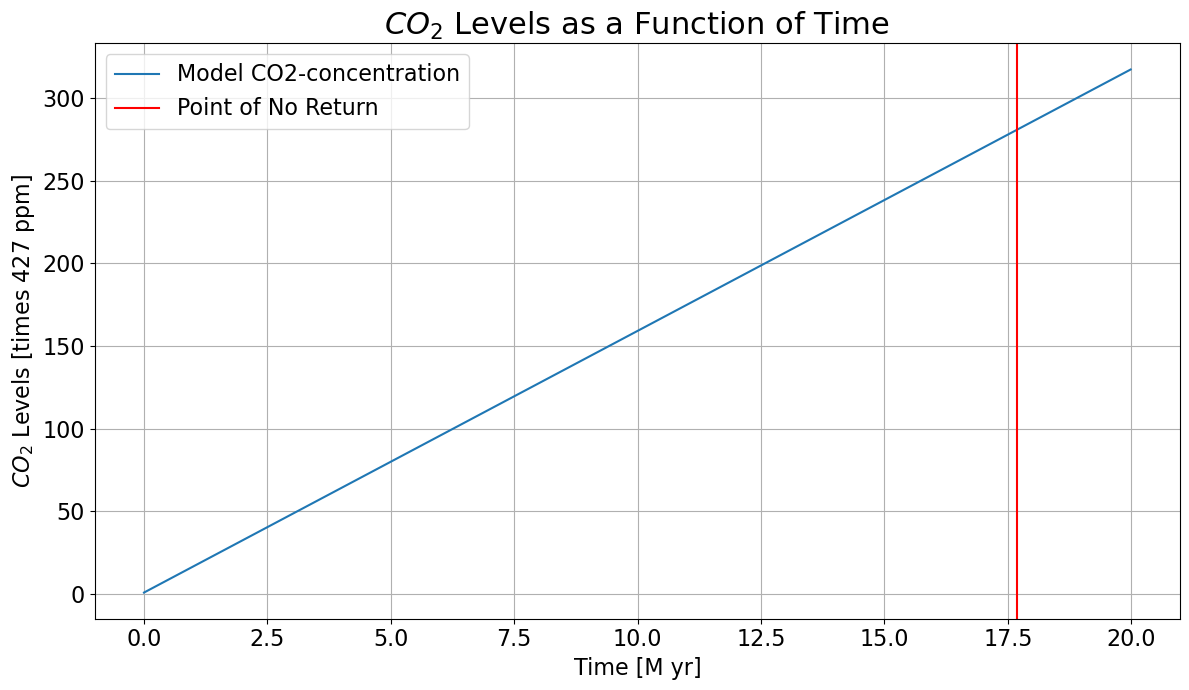

In [65]:
fig, ax = plt.subplots(figsize=(12, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

ax.plot(time_scale_arr/(10**6), CO2_PPM_array/427, label = 'Model CO2-concentration')

ax.set_xlabel('Time [M yr]', fontsize=16)
ax.set_ylabel(r'$CO_2$ Levels [times 427 ppm]', fontsize=16)
ax.set_title(r'$CO_2$ Levels as a Function of Time', fontsize=22)
ax.axvline(x = time_scale_arr[1769]/(10**6), c = 'r', label = 'Point of No Return')
ax.legend(fontsize = 16, loc = 'best')


ax.tick_params(labelsize = 16)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'CO2-levels_time'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')


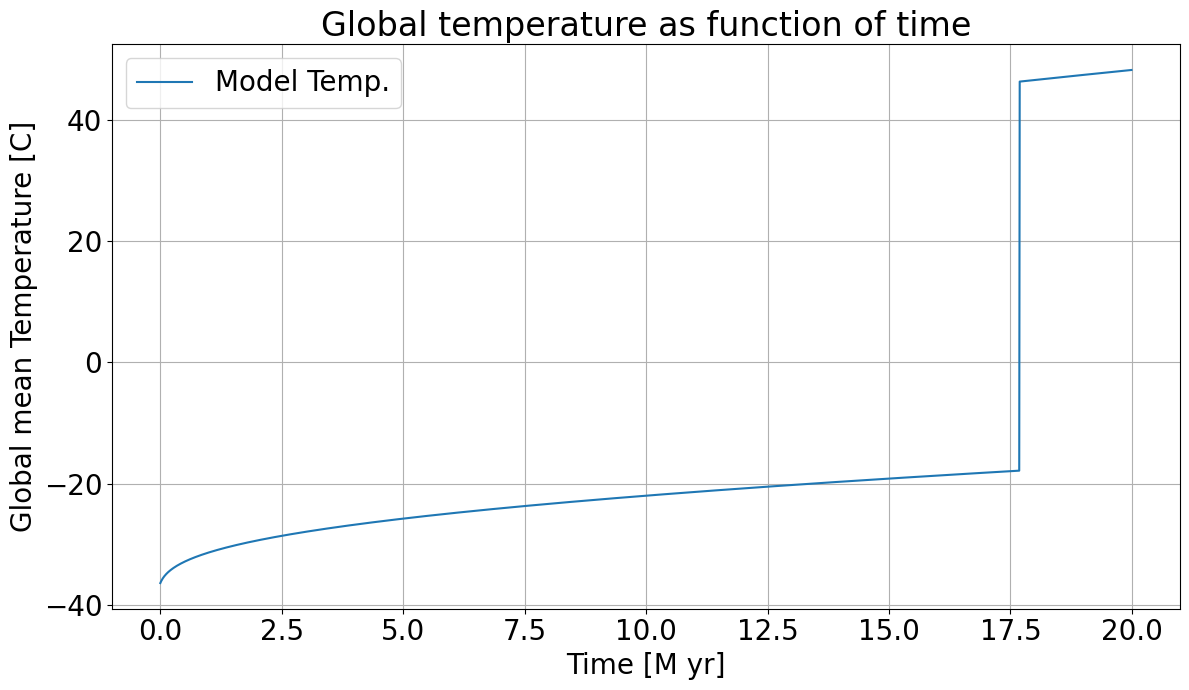

In [66]:
fig, ax = plt.subplots(figsize=(12, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

ax.plot(time_scale_arr/(10**6), Tglob_array, label = 'Model Temp.')

ax.legend(fontsize = 20, loc = 'best')
ax.set_xlabel('Time [M yr]', fontsize=20)
ax.set_ylabel('Global mean Temperature [C]', fontsize=20)
ax.set_title('Global temperature as function of time', fontsize=24)

ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Temperature_time'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')


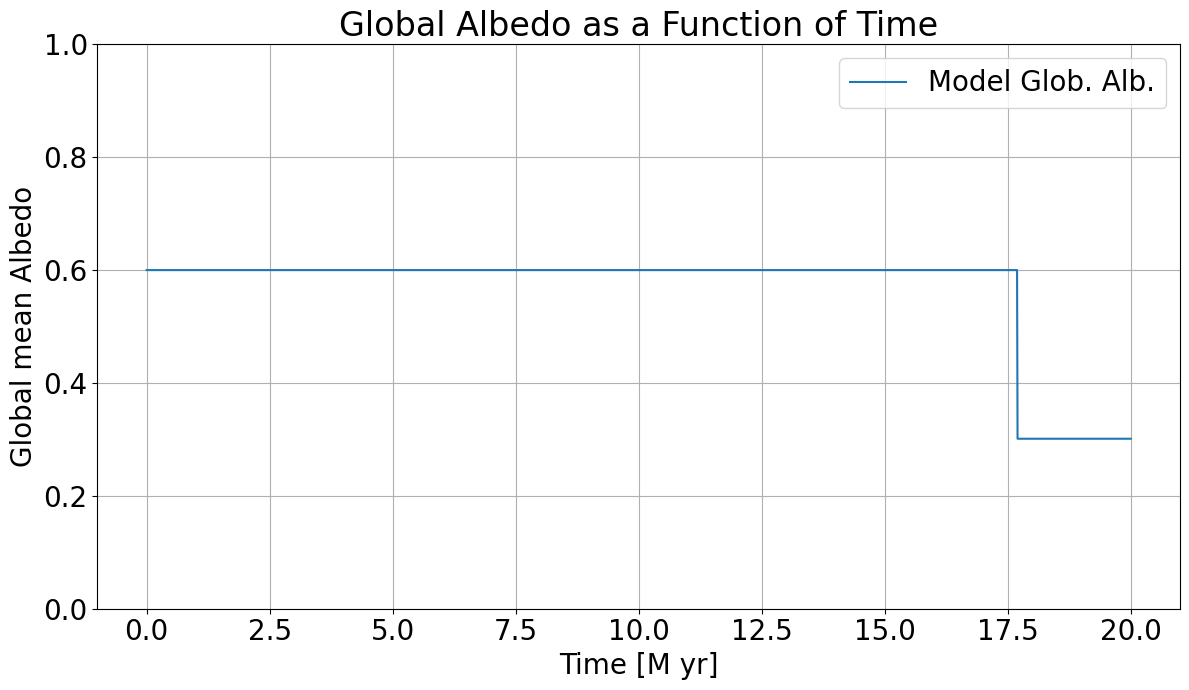

In [67]:
fig, ax = plt.subplots(figsize=(12, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

ax.plot(time_scale_arr/(10**6), np.mean(alb_array, axis = 1), label = 'Model Glob. Alb.')

ax.legend(fontsize = 20, loc = 'best')
ax.set_xlabel('Time [M yr]', fontsize = 20)
ax.set_ylabel('Global mean Albedo', fontsize = 20)
ax.set_title('Global Albedo as a Function of Time', fontsize = 24)

ax.set_ylim(ymin = 0, ymax = 1)

ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Albedo_time'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')

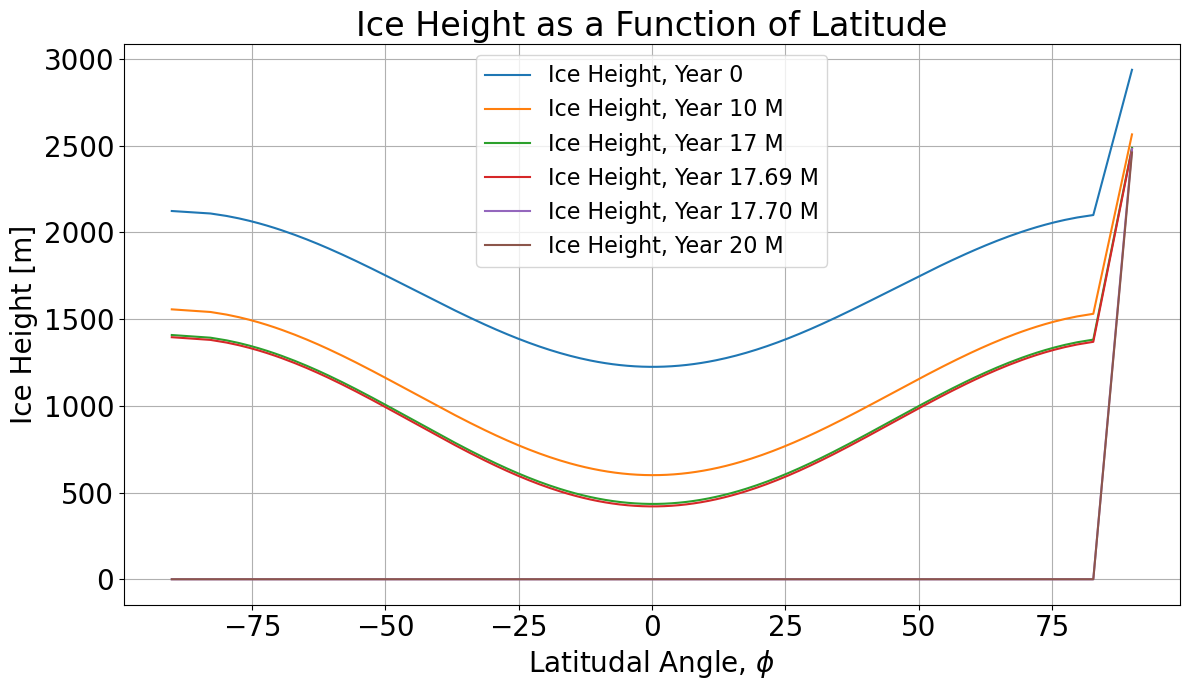

In [69]:
fig, ax = plt.subplots(figsize=(12, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

Ice_h_array = K * (T_B - T_array) / Q 
mask_arr = Ice_h_array < 0
Ice_h_array[mask_arr] = 0


ax.plot(phi, Ice_h_array[0, :], label = 'Ice Height, Year 0')
ax.plot(phi, Ice_h_array[999, :], label = 'Ice Height, Year 10 M')
ax.plot(phi, Ice_h_array[1699, :], label = 'Ice Height, Year 17 M')
ax.plot(phi, Ice_h_array[1768, :], label = 'Ice Height, Year 17.69 M')
ax.plot(phi, Ice_h_array[1769, :], label = 'Ice Height, Year 17.70 M')
ax.plot(phi, Ice_h_array[-1, :], label = 'Ice Height, Year 20 M')


ax.legend(fontsize = 16, loc = 'best')
ax.set_xlabel(r'Latitudal Angle, $\phi$', fontsize = 20)
ax.set_ylabel('Ice Height [m]', fontsize = 20)
ax.set_title('Ice Height as a Function of Latitude', fontsize = 24)


ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Ice_Latitude'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')

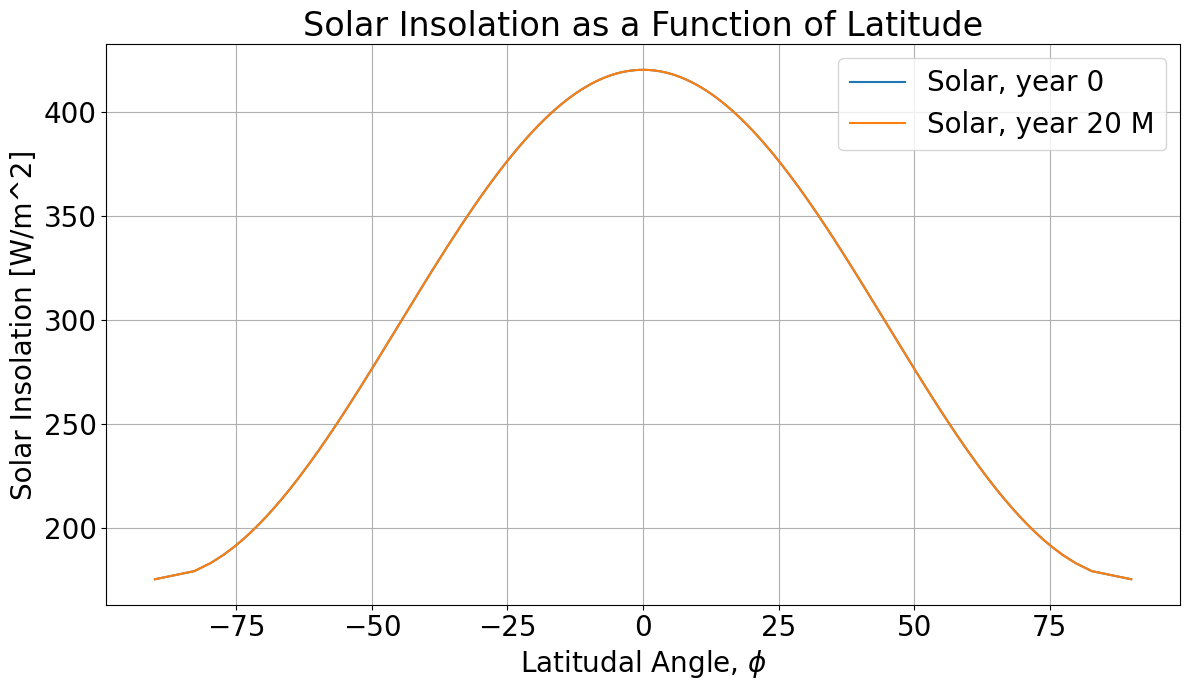

In [71]:
fig, ax = plt.subplots(figsize=(12, 7))

ax.plot(phi, S_array[0], label = 'Solar, year 0')
ax.plot(phi, S_array[-1], label = 'Solar, year 20 M')

ax.legend(fontsize = 20, loc = 'best')
ax.set_xlabel(r'Latitudal Angle, $\phi$', fontsize = 20)
ax.set_ylabel('Solar Insolation [W/m^2]', fontsize = 20)
ax.set_title('Solar Insolation as a Function of Latitude', fontsize = 24)

ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Solar_Latitude'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')

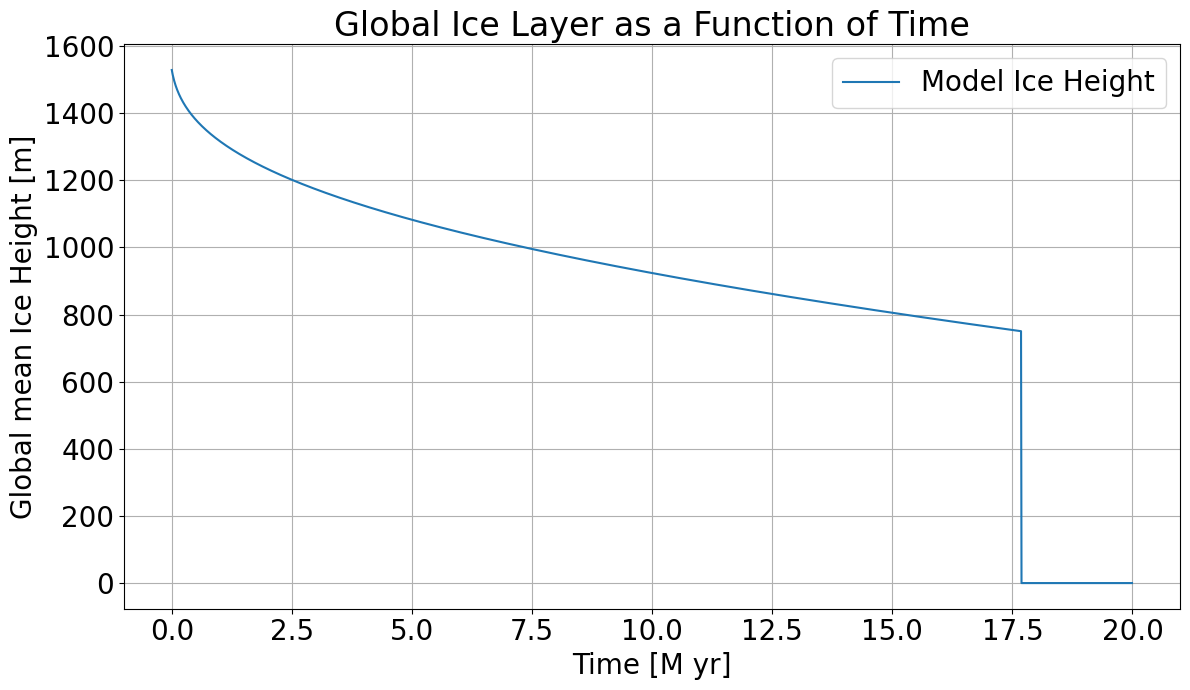

In [83]:
fig, ax = plt.subplots(figsize=(12, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

ax.plot(time_scale_arr/(10**6), Ice_h, label = 'Model Ice Height')

ax.legend(fontsize = 20, loc = 'best')
ax.set_xlabel('Time [M yr]', fontsize = 20)
ax.set_ylabel('Global mean Ice Height [m]', fontsize = 20)
ax.set_title('Global Ice Layer as a Function of Time', fontsize = 24)


ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Ice_Global_Time'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')

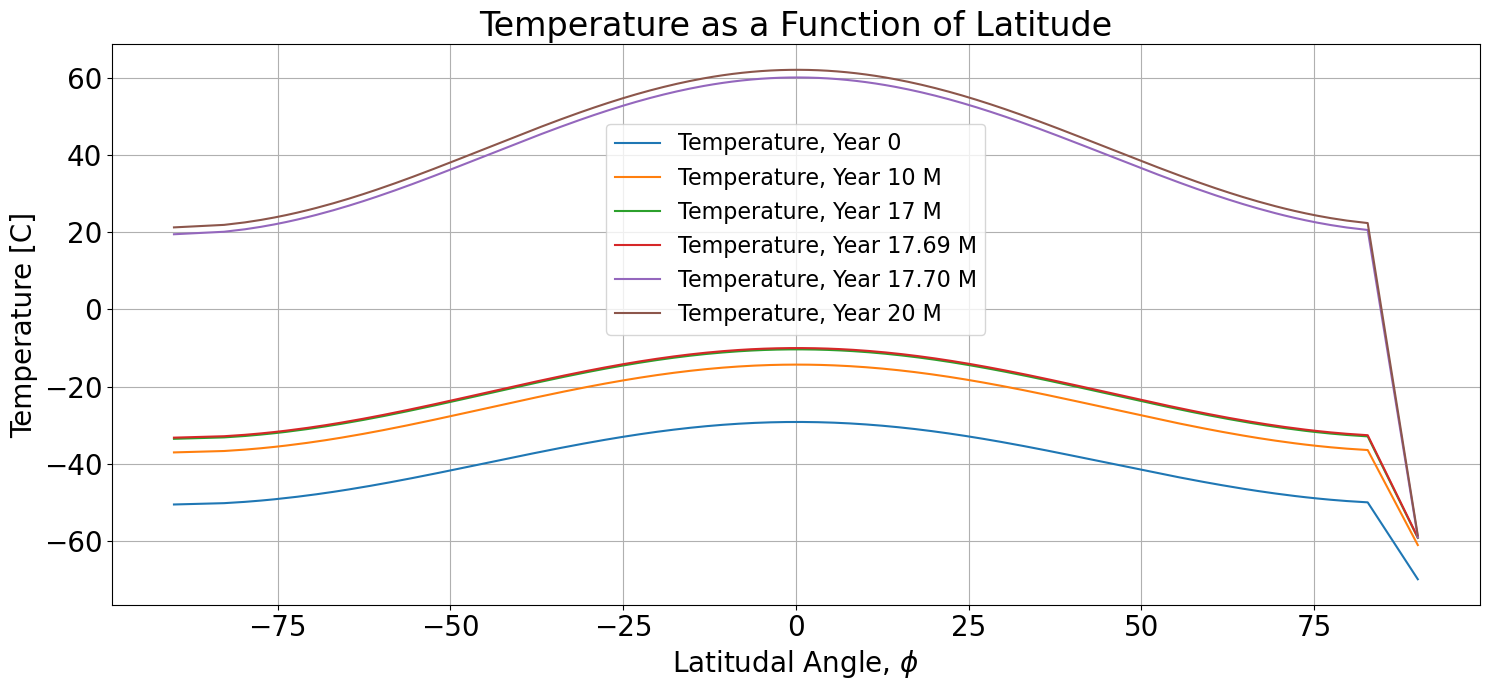

In [82]:
fig, ax = plt.subplots(figsize=(15, 7))

time_scale_arr = np.arange(0, time_scale, time_step)

ax.plot(phi, T_array[0, :], label = 'Temperature, Year 0')
ax.plot(phi, T_array[999, :], label = 'Temperature, Year 10 M')
ax.plot(phi, T_array[1699, :], label = 'Temperature, Year 17 M')
ax.plot(phi, T_array[1768, :], label = 'Temperature, Year 17.69 M')
ax.plot(phi, T_array[1769, :], label = 'Temperature, Year 17.70 M')
ax.plot(phi, T_array[-1, :], label = 'Temperature, Year 20 M')


ax.legend(fontsize = 16, loc = 'center', bbox_to_anchor=(0.5, 0.67))
ax.set_xlabel(r'Latitudal Angle, $\phi$', fontsize = 20)
ax.set_ylabel('Temperature [C]', fontsize = 20)
ax.set_title('Temperature as a Function of Latitude', fontsize = 24)


ax.tick_params(labelsize = 20)
ax.grid(True)

# Set your path and name
path = 'Plots_of_Snowball'
name = 'Temperature_Latitude'
    
# Ensure the directory exists
os.makedirs(path, exist_ok=True)
    
# Build full file path
full_path = os.path.join(path, name + '.png')
    
# Save the figure

fig.tight_layout()
fig.savefig(full_path, dpi=300, bbox_inches='tight', facecolor='white')

In [48]:
print(Ice_h)

[1528.58545057 1520.76502989 1513.79020132 ...    0.            0.
    0.        ]


def north_model(T_input, A_val, B_val, D_arr, L=1, hadleyflag=0, albedoflag=1):
    
    A = A_val + B_val * 273.15
    B = B_val
    D = D_arr
    T = T_input
    
    # Calculate an array of annual mean insolation for the latitudes steps
    S = Q_lat(x, L, S0) 
    
    # Calculate global mean temperature
    Tglob=np.mean(T) #ok to take the mean when we use x
    
    # Calculate initial albedo
    alb=albedo(T, x, jmx, albedoflag)
    
    # Initial boundary conditions
    src = (1 - alb) * S/Cl - A/Cl
    Mh = setupfastMh(delx, jmx, D, B, Cl, delt)
    invM = setupfastinvM(Mh, jmx, delt)
    h = np.dot(Mh, T) + src
    
    for n in range(NMAX): #Should be NMAX
        Tglob_prev = Tglob
        # calculate src for this loop
        alb = albedo(T, x, jmx, albedoflag)
        src = (1 - alb) * S/Cl - A/Cl
        # Calculate new T.
        T = -np.dot(invM, 0.5* (h + src) + T/delt)

        # Calculate h for next loop.
        h = np.dot(Mh, T) + src
        # Check to see if global mean temperature has converged
        Tglob = np.mean(T)
        #print(Tglob)
        Tchange = Tglob - Tglob_prev
        if abs(Tchange)< 1e-12:
            break

    # Compute meridional heat flux and its convergence
    a = 6.37e+6; # earth radius in meters
    Mh = setupfastMh(delx, jmx, D, 0, 1, delt)
    invM = setupfastinvM(Mh, jmx, delt)
    Dmp = D[0:jmx]
    divF = np.dot(Mh, T)
    F = -2 * math.pi * a * a * np.sqrt(1 - x*x) * Dmp * np.gradient(T, delx)
    
    return T, Tglob, F, alb, S



# Start time-stepping loop

def one_time_step(Tglob_ini, T_ini, alb_ini, A_val, B_val):
    Tglob = Tglob_ini
    
    for n in range(NMAX): #Should be NMAX
        Tglob_prev = Tglob
        # calculate src for this loop
        alb = albedo(T, jmx, albedoflag)
        src = (1 - alb) * S/Cl - A/Cl
        # Calculate new T.
        T = -np.dot(invM, 0.5* (h + src) + T/delt)

        # Calculate h for next loop.
        h = np.dot(Mh, T) + src
        # Check to see if global mean temperature has converged
        Tglob = np.mean(T)
        #print(Tglob)
        Tchange = Tglob - Tglob_prev
        if abs(Tchange)< 1e-12:
            break